# **Data Source:**
https://www.kaggle.com/datasets/sobhanmoosavi/us-accidents; https://www.iihs.org/topics/fatality-statistics

## **Import Modules**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## **Read Raw Data**

In [2]:
dataRaw=pd.read_csv('./US_Accidents_Dec21_updated.csv', header=0)

In [3]:
dataRaw.columns.to_list()

['ID',
 'Severity',
 'Start_Time',
 'End_Time',
 'Start_Lat',
 'Start_Lng',
 'End_Lat',
 'End_Lng',
 'Distance(mi)',
 'Description',
 'Number',
 'Street',
 'Side',
 'City',
 'County',
 'State',
 'Zipcode',
 'Country',
 'Timezone',
 'Airport_Code',
 'Weather_Timestamp',
 'Temperature(F)',
 'Wind_Chill(F)',
 'Humidity(%)',
 'Pressure(in)',
 'Visibility(mi)',
 'Wind_Direction',
 'Wind_Speed(mph)',
 'Precipitation(in)',
 'Weather_Condition',
 'Amenity',
 'Bump',
 'Crossing',
 'Give_Way',
 'Junction',
 'No_Exit',
 'Railway',
 'Roundabout',
 'Station',
 'Stop',
 'Traffic_Calming',
 'Traffic_Signal',
 'Turning_Loop',
 'Sunrise_Sunset',
 'Civil_Twilight',
 'Nautical_Twilight',
 'Astronomical_Twilight']

In [4]:
data = dataRaw

## **Drop Redundant/unrelated Columns**

In [5]:
data = data.drop(
['ID',
 'End_Lat',
 'End_Lng',
 'Number',
 'Street',
 'Zipcode',
 'Country',
 'Timezone',
 'Airport_Code',
 'Weather_Timestamp',
 'Turning_Loop'  # All values in Turning_Loop are 'False'
], axis=1)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2845342 entries, 0 to 2845341
Data columns (total 36 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Severity               int64  
 1   Start_Time             object 
 2   End_Time               object 
 3   Start_Lat              float64
 4   Start_Lng              float64
 5   Distance(mi)           float64
 6   Description            object 
 7   Side                   object 
 8   City                   object 
 9   County                 object 
 10  State                  object 
 11  Temperature(F)         float64
 12  Wind_Chill(F)          float64
 13  Humidity(%)            float64
 14  Pressure(in)           float64
 15  Visibility(mi)         float64
 16  Wind_Direction         object 
 17  Wind_Speed(mph)        float64
 18  Precipitation(in)      float64
 19  Weather_Condition      object 
 20  Amenity                bool   
 21  Bump                   bool   
 22  Crossing          

## **Bisect the "Severity"**

In [6]:
# In 2021, the orignial 4 levels are reduced to 2 levels
# Transform the Severity feature to 2-level.

In [7]:
lab = [f'{i}' for i in range(0, 2)]
tmp = (pd.cut(x=data.Severity, bins=2, labels=lab)).astype(int, errors = 'raise')
data['Severity_Bisection']=tmp

In [8]:
print(data['Severity_Bisection'].value_counts())

0    2559044
1     286298
Name: Severity_Bisection, dtype: int64


## **Wind Direction = Calm**

In [9]:
# When Wind Direction is Calm, the value of Wind_Chill(F) and Wind_Speed(mph) will be null,
# which is not reasonable.

In [10]:
ind = (data['Wind_Direction'] == 'Calm')

In [11]:
data.loc[ind,'Wind_Speed(mph)'] = 0
data.loc[ind, 'Wind_Chill(F)'] = data['Temperature(F)']

## **Drop all the null Values**

In [12]:
data.isna().sum()

Severity                      0
Start_Time                    0
End_Time                      0
Start_Lat                     0
Start_Lng                     0
Distance(mi)                  0
Description                   0
Side                          0
City                        137
County                        0
State                         0
Temperature(F)            69274
Wind_Chill(F)            393478
Humidity(%)               73092
Pressure(in)              59200
Visibility(mi)            70546
Wind_Direction            73775
Wind_Speed(mph)           81410
Precipitation(in)        549458
Weather_Condition         70636
Amenity                       0
Bump                          0
Crossing                      0
Give_Way                      0
Junction                      0
No_Exit                       0
Railway                       0
Roundabout                    0
Station                       0
Stop                          0
Traffic_Calming               0
Traffic_

In [13]:
data = data.dropna()
data = data.reset_index(drop=True)
# data.isna().sum()

## **Starting Date & Feature Etraction(weekday, Month)**

In [14]:
import datetime
data['Start_Time'] = pd.to_datetime(data['Start_Time'], errors='coerce')
date = pd.to_datetime(data['Start_Time'], errors='coerce').dt.date
print('The Srarting Date is {}'.format(date.min()))

The Srarting Date is 2016-01-14


In [15]:
data['Weekday']=data['Start_Time'].dt.strftime('%a')
data['Weekday'].head()

0    Mon
1    Mon
2    Mon
3    Mon
4    Mon
Name: Weekday, dtype: object

In [16]:
weekday = data['Weekday'].value_counts().index.tolist()
print(weekday)

['Fri', 'Thu', 'Wed', 'Tue', 'Mon', 'Sat', 'Sun']


In [17]:
data['SeverityRatio_Weekday'] = 0.0
for day in weekday:
    ind = (data['Weekday'] == day)
    tmpData = data[ind]
    severityRatio = ((tmpData['Severity_Bisection'] == 1).sum())/((tmpData['Severity_Bisection'] == 0).sum())
    print(day, severityRatio)
    data.loc[ind, 'SeverityRatio_Weekday'] = severityRatio

Fri 0.06259559915327463
Thu 0.06317581821469472
Wed 0.06232157501094443
Tue 0.06357496508011597
Mon 0.06547702872164216
Sat 0.05237206091179401
Sun 0.05935605340044972


In [18]:
data['Month'] = data['Start_Time'].dt.strftime('%b')

In [19]:
months = data['Month'].value_counts().index.tolist()
data['SeverityRatio_Month'] = 0.0
for m in months:
    ind = (data['Month'] == m)
    tmpData = data[ind]
    severityRatio = ((tmpData['Severity_Bisection'] == 1).sum())/((tmpData['Severity_Bisection'] == 0).sum())
    print(m, severityRatio)
    data.loc[ind, 'SeverityRatio_Month'] = severityRatio

Dec 0.02496940960538391
Nov 0.025970507008493564
Oct 0.03295191942882765
Sep 0.0369620757158499
Jun 0.13957688174436128
Feb 0.04664122468450497
Jan 0.052837444618286565
May 0.16635167032062428
Apr 0.16619782492485388
Aug 0.050660174946360784
Jul 0.05402215531021152
Mar 0.10813358884231884


# **Day-Night Data**

In [20]:
subData = data[['Severity',
                'Severity_Bisection',
                'Sunrise_Sunset',
                'Civil_Twilight',
                'Nautical_Twilight',
                'Astronomical_Twilight']]

subData.head(10)

,Severity,Severity_Bisection,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,3,1,Night,Night,Night,Night
1,2,0,Night,Night,Night,Night
2,2,0,Night,Night,Night,Day
3,3,1,Day,Day,Day,Day
4,2,0,Day,Day,Day,Day
5,2,0,Day,Day,Day,Day
6,2,0,Day,Day,Day,Day
7,2,0,Day,Day,Day,Day
8,2,0,Day,Day,Day,Day
9,3,1,Night,Night,Night,Night


In [21]:
print(len(subData))

identifierAT = subData['Astronomical_Twilight'] == 'Night'

identifierNT = subData['Nautical_Twilight'] == 'Night'
identifierNT[identifierAT] = False

identifierCT = subData['Civil_Twilight'] == 'Night'
identifierCT[identifierAT | identifierNT] = False

identifierSS = subData['Sunrise_Sunset'] == 'Night'
identifierSS[identifierAT | identifierNT | identifierCT] = False

identifierDay = (subData['Sunrise_Sunset'] == 'Day') & (subData['Nautical_Twilight'] == 'Day')\
& (subData['Astronomical_Twilight'] == 'Day') & (subData['Civil_Twilight'] == 'Day') 

print('AT = ', identifierAT.sum())
print('NT = ', identifierNT.sum())
print('CT = ', identifierCT.sum())
print('SS = ', identifierSS.sum())
#print('Day = ', len(subData)-identifierAT.sum()-identifierNT.sum()-identifierCT.sum()-identifierSS.sum())
print('Day = ', identifierDay.sum())

2213344
AT =  552409
NT =  90596
CT =  104408
SS =  88970
Day =  1376961


In [22]:
identifierSeverity4 = data['Severity'] == 4
print('level 4 and Astronomical Twilight:\t', (identifierSeverity4 & identifierAT).sum())
print('level 4 and Nautical Twilight:\t\t', (identifierSeverity4 & identifierNT).sum())
print('level 4 and Civil Twilight:\t\t', (identifierSeverity4 & identifierCT).sum())
print('level 4 and Sunrise/Sunset:\t\t', (identifierSeverity4 & identifierSS).sum())
print('level 4 and Bright Day:\t\t\t', (identifierSeverity4 & identifierDay).sum())
print('===========================================')

identifierSeverity3 = data['Severity'] == 3
print('level 3 and Astronomical Twilight:\t', (identifierSeverity3 & identifierAT).sum())
print('level 3 and Nautical Twilight:\t\t', (identifierSeverity3 & identifierNT).sum())
print('level 3 and Civil Twilight:\t\t', (identifierSeverity3 & identifierCT).sum())
print('level 3 and Sunrise/Sunset:\t\t', (identifierSeverity3 & identifierSS).sum())
print('level 3 and Bright Day:\t\t\t', (identifierSeverity3 & identifierDay).sum())
print('===========================================')

identifierSeverity2 = data['Severity'] == 2
print('level 2 and Astronomical Twilight:\t', (identifierSeverity2 & identifierAT).sum())
print('level 2 and Nautical Twilight:\t\t', (identifierSeverity2 & identifierNT).sum())
print('level 2 and Civil Twilight:\t\t', (identifierSeverity2 & identifierCT).sum())
print('level 2 and Sunrise/Sunset:\t\t', (identifierSeverity2 & identifierSS).sum())
print('level 2 and Bright Day:\t\t\t', (identifierSeverity2 & identifierDay).sum())
print('===========================================')

identifierSeverity1 = data['Severity'] == 1
print('level 1 and Astronomical Twilight:\t', (identifierSeverity1 & identifierAT).sum())
print('level 1 and Nautical Twilight:\t\t', (identifierSeverity1 & identifierNT).sum())
print('level 1 and Civil Twilight:\t\t', (identifierSeverity1 & identifierCT).sum())
print('level 1 and Sunrise/Sunset:\t\t', (identifierSeverity1 & identifierSS).sum())
print('level 1 and Bright Day:\t\t\t', (identifierSeverity1 & identifierDay).sum())
print('===========================================')

level 4 and Astronomical Twilight:	 18169
level 4 and Nautical Twilight:		 2705
level 4 and Civil Twilight:		 2715
level 4 and Sunrise/Sunset:		 2462
level 4 and Bright Day:			 36874
level 3 and Astronomical Twilight:	 9495
level 3 and Nautical Twilight:		 2173
level 3 and Civil Twilight:		 2386
level 3 and Sunrise/Sunset:		 2366
level 3 and Bright Day:			 49156
level 2 and Astronomical Twilight:	 522793
level 2 and Nautical Twilight:		 85152
level 2 and Civil Twilight:		 98642
level 2 and Sunrise/Sunset:		 83405
level 2 and Bright Day:			 1271295
level 1 and Astronomical Twilight:	 1952
level 1 and Nautical Twilight:		 566
level 1 and Civil Twilight:		 665
level 1 and Sunrise/Sunset:		 737
level 1 and Bright Day:			 19636


In [23]:
data['SeverityRatio_Light'] = 0.0

tmp = data[identifierAT]
data.loc[identifierAT, 'SeverityRatio_Light'] = (tmp.Severity_Bisection == 1).sum() / (tmp.Severity_Bisection == 0).sum()

tmp = data[identifierNT]
data.loc[identifierNT, 'SeverityRatio_Light'] = (tmp.Severity_Bisection == 1).sum() / (tmp.Severity_Bisection == 0).sum()

tmp = data[identifierCT]
data.loc[identifierCT, 'SeverityRatio_Light'] = (tmp.Severity_Bisection == 1).sum() / (tmp.Severity_Bisection == 0).sum()

tmp = data[identifierSS]
data.loc[identifierSS, 'SeverityRatio_Light'] = (tmp.Severity_Bisection == 1).sum() / (tmp.Severity_Bisection == 0).sum()

tmp = data[identifierDay]
data.loc[identifierDay, 'SeverityRatio_Light'] = (tmp.Severity_Bisection == 1).sum() / (tmp.Severity_Bisection == 0).sum()

### Transform of day-night

In [24]:
# Classification 1
data['DayNight'] = 'Bright'
data.loc[data['Astronomical_Twilight']=='Night', 'DayNight'] = 'Dark'
identifier = (data['Astronomical_Twilight']=='Day') & (data['Sunrise_Sunset']=='Night')
data.loc[identifier, 'DayNight'] = 'Dim'

In [25]:
# Classification 2
data['Light'] = 'Day'
data.loc[data['Astronomical_Twilight']=='Night', 'Light'] = 'AT'
data.loc[identifierNT, 'Light'] = 'NT'
data.loc[identifierCT, 'Light'] = 'CT'
data.loc[identifierSS, 'Light'] = 'SS'

# **Weather Related Features**

In [26]:
subData = data[['Severity',
                'Severity_Bisection',
                'Temperature(F)',
                'Wind_Chill(F)',
                'Humidity(%)',
                'Pressure(in)',
                'Visibility(mi)',
                'Wind_Direction',
                'Wind_Speed(mph)',
                'Precipitation(in)',
                'Weather_Condition']]
subData.head(10)

,Severity,Severity_Bisection,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition
0,3,1,42.1,36.1,58.0,29.76,10.0,SW,10.4,0.00,Light Rain
1,2,0,36.9,36.9,91.0,29.68,10.0,Calm,0.0,0.02,Light Rain
2,2,0,36.0,36.0,97.0,29.70,10.0,Calm,0.0,0.02,Overcast
3,3,1,37.0,29.8,93.0,29.69,10.0,WSW,10.4,0.01,Light Rain
4,2,0,33.1,30.0,92.0,29.63,0.5,SW,3.5,0.08,Snow
5,2,0,32.0,28.7,100.0,29.59,0.5,West,3.5,0.05,Snow
6,2,0,33.8,29.6,100.0,29.66,3.0,NNW,4.6,0.03,Light Snow
7,2,0,33.1,24.4,96.0,29.59,1.8,West,11.5,0.00,Light Snow
8,2,0,33.8,28.6,93.0,29.64,1.0,West,5.8,0.01,Light Snow
9,3,1,34.0,34.0,100.0,29.65,6.0,Calm,0.0,0.07,Overcast


## Weather_Condition : Bisection & Severity Ratio

In [27]:
severityRatioAllFor = (subData['Severity_Bisection']==1).sum() / (subData['Severity_Bisection']==0).sum()
print(severityRatioAllFor)

0.061635816222132794


In [28]:
weatherConditions = subData['Weather_Condition'].value_counts().index.tolist()

tmpList = [0, 0, 0, 0]
weatherConditionSeverity = dict()
weatherConditionSeverityRatio = dict()
# data['Weather_Condition_SeverityRatio_denum'] =1.0

for weather in weatherConditions:
    identifier = subData['Weather_Condition'] == weather
    tmpData = subData[identifier]
    
    # data.loc[identifier, 'Weather_Condition_SeverityRatio_denum'] = (tmpData['Severity_Bisection'] == 1).sum()
    weatherSeverityCount = tmpData['Severity'].value_counts()
    
    tmpList = [0, 0, 0, 0]
    for idx in weatherSeverityCount.keys():
        tmpList[idx-1] = weatherSeverityCount[idx]
        
    if (tmpList[0] + tmpList[1]) == 0:
        weatherConditionSeverity.update({weather:'BadWeather'})
        severityRatioWeatherFor = (tmpList[3] + tmpList[2])/ 1.0
        weatherConditionSeverityRatio.update({weather:severityRatioWeatherFor})
    else:
        severityRatioWeatherFor = (tmpList[3] + tmpList[2]) / (tmpList[0] + tmpList[1])
        weatherConditionSeverityRatio.update({weather:severityRatioWeatherFor})
        if severityRatioWeatherFor > severityRatioAllFor:
            weatherConditionSeverity.update({weather:'BadWeather'})
        else:
            weatherConditionSeverity.update({weather:'GoodWeather'})

    ## Depict Weather Severities
#     plt.title(weather)
#     plt.xlabel('Severity')
#     plt.ylabel('Counts')
#     plt.bar(['1','2','3','4'], tmpList)
    
#     if "/" in weather:
#         weather = weather.replace("/", "-")
        
#     plt.savefig('./Weather_Condition'+str(weather)+'.png')
#     plt.clf()

data['Bisection_WeatherCondition']= 'GoodWeather'
data['SeverityRatio_WeatherCondition']= 0.0
for i, (key, value) in enumerate(weatherConditionSeverity.items()):    
    identifier = (data['Weather_Condition'] == key)
    data.loc[identifier, 'Bisection_WeatherCondition'] = value
    
for i, (key, value) in enumerate(weatherConditionSeverityRatio.items()):    
    identifier = (data['Weather_Condition'] == key)
    data.loc[identifier, 'SeverityRatio_WeatherCondition'] = value

## Visibility(mi): Bisection & Severity Ratio

In [29]:
identifierSeverity4 = (subData['Severity'] == 4)
identifierSeverity3 = (subData['Severity'] == 3)
identifierSeverity2 = (subData['Severity'] == 2)
identifierSeverity1 = (subData['Severity'] == 1)

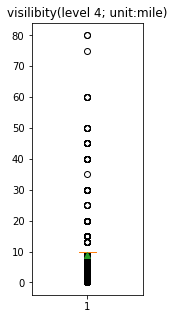

In [30]:
visibilitySeverity4 = subData['Visibility(mi)'][identifierSeverity4]
plt.figure(figsize=(2,5))
plt.boxplot(visibilitySeverity4,showmeans=True)
plt.title('visilibity(level 4; unit:mile)')
plt.show()

<Level 4>
Visibility > 10(mi); Number of Events =  249
Visibility = 10(mi); Number of Events = 49028
Visibility < 10(mi); Number of Events = 13648
[5.7860e+03 5.3340e+03 5.1556e+04 1.1500e+02 0.0000e+00 6.2000e+01
 5.0000e+00 2.6000e+01 1.0000e+00 0.0000e+00 1.6000e+01 1.0000e+01]


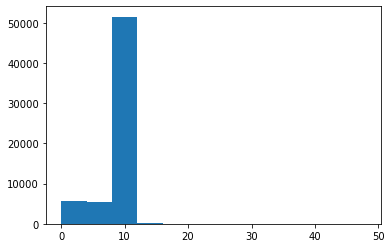

In [31]:
sector = 12
x_max = 48
x_min = 0

print('<Level 4>')
print('==============================================')
print("Visibility > 10(mi); Number of Events = ", len(visibilitySeverity4[visibilitySeverity4>10.0]))
print("Visibility = 10(mi); Number of Events =", len(visibilitySeverity4[visibilitySeverity4==10.0]))
print("Visibility < 10(mi); Number of Events =", len(visibilitySeverity4[visibilitySeverity4<10.0]))
print('==============================================')

severityCount4, x_visibility, c = plt.hist(visibilitySeverity4, sector, [x_min,x_max] )
print(severityCount4)

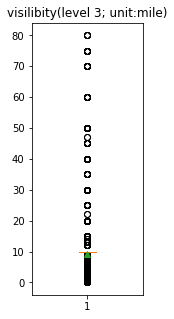

In [32]:
visibilitySeverity3 = subData['Visibility(mi)'][identifierSeverity3]
plt.figure(figsize=(2,5))
plt.boxplot(visibilitySeverity3,showmeans=True)
plt.title('visilibity(level 3; unit:mile)')
plt.show()

<Level 3>
Visibility > 10(mi); Number of Events =  847
Visibility = 10(mi); Number of Events = 50399
Visibility < 10(mi); Number of Events = 14330


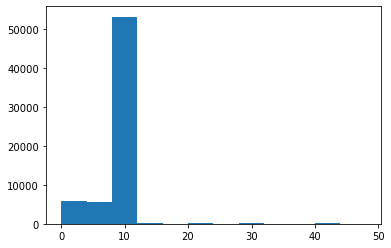

In [33]:
print('<Level 3>')
print('==============================================')
print("Visibility > 10(mi); Number of Events = ", len(visibilitySeverity3[visibilitySeverity3>10.0]))
print("Visibility = 10(mi); Number of Events =", len(visibilitySeverity3[visibilitySeverity3==10.0]))
print("Visibility < 10(mi); Number of Events =", len(visibilitySeverity3[visibilitySeverity3<10.0]))
print('==============================================')

severityCount3, x_visibility, c = plt.hist(visibilitySeverity3, sector, [x_min,x_max] )

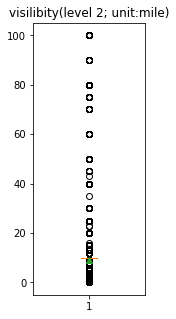

In [34]:
visibilitySeverity2 = subData['Visibility(mi)'][identifierSeverity2]
plt.figure(figsize=(2,5))
plt.boxplot(visibilitySeverity2,showmeans=True)
plt.title('visilibity(level 2; unit:mile)')
plt.show()

<Level 2>
Visibility > 10(mi); Number of Events =  5008
Visibility = 10(mi); Number of Events = 1648718
Visibility < 10(mi); Number of Events = 407561


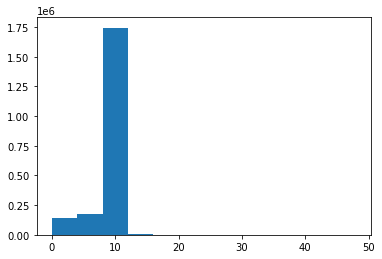

In [35]:
print('<Level 2>')
print('==============================================')
print("Visibility > 10(mi); Number of Events = ", len(visibilitySeverity2[visibilitySeverity2>10.0]))
print("Visibility = 10(mi); Number of Events =", len(visibilitySeverity2[visibilitySeverity2==10.0]))
print("Visibility < 10(mi); Number of Events =", len(visibilitySeverity2[visibilitySeverity2<10.0]))
print('==============================================')

severityCount2, x_visibility, c = plt.hist(visibilitySeverity2, sector, [x_min,x_max] )

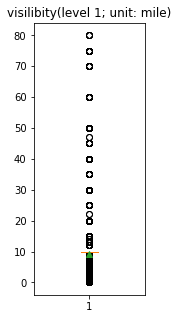

In [36]:
visibilitySeverity1 = subData['Visibility(mi)'][identifierSeverity3]
plt.figure(figsize=(2,5))
plt.boxplot(visibilitySeverity1,showmeans=True)
plt.title('visilibity(level 1; unit: mile)')
plt.show()

<Level 1>
Visibility > 10(mi); Number of Events =  847
Visibility = 10(mi); Number of Events = 50399
Visibility < 10(mi); Number of Events = 14330


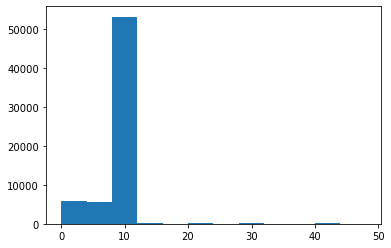

In [37]:
print('<Level 1>')
print('==============================================')
print("Visibility > 10(mi); Number of Events = ", len(visibilitySeverity1[visibilitySeverity1>10.0]))
print("Visibility = 10(mi); Number of Events =", len(visibilitySeverity1[visibilitySeverity1==10.0]))
print("Visibility < 10(mi); Number of Events =", len(visibilitySeverity1[visibilitySeverity1<10.0]))
print('==============================================')

severityCount1, x_visibility, c = plt.hist(visibilitySeverity1, sector, [x_min,x_max] )

In [38]:
tmpData = subData[subData['Visibility(mi)']>10.0]
SeverityRatio10MilesMore = (tmpData['Severity_Bisection']==1).sum() / (tmpData['Severity_Bisection']==0).sum()

tmpData = subData[subData['Visibility(mi)']==10.0]
SeverityRatio10Miles = (tmpData['Severity_Bisection']==1).sum() / (tmpData['Severity_Bisection']==0).sum()

tmpData = subData[subData['Visibility(mi)']<10.0]
SeverityRatio10MilesLess = (tmpData['Severity_Bisection']==1).sum() / (tmpData['Severity_Bisection']==0).sum()

print(f'>10miles: Severity Ratio = {SeverityRatio10MilesMore}')
print(f'=10miles: Severity Ratio = {SeverityRatio10Miles}')
print(f'<10miles: Severity Ratio = {SeverityRatio10MilesLess}')

>10miles: Severity Ratio = 0.21418800078170802
=10miles: Severity Ratio = 0.05955392209419543
<10miles: Severity Ratio = 0.06820625211788482


In [39]:
# Since the Severity Ratios are silmilar when the visibility is 10 miles or larger the 10 miles,
# 10 miles is a good criterion for bisection
data['Visibility_Bisection'] = 'level_1'
data.loc[data['Visibility(mi)'] >10.0, 'Visibility_Bisection'] = 'level_2'

In [40]:
data['SeverityRatio_Visibility'] = 0.0
identifier = (data['Visibility_Bisection'] == 'level_1')
tmp = data[identifier]
data.loc[identifier, 'SeverityRatio_Visibility'] = (tmp['Severity_Bisection']==1).sum()/(tmp['Severity_Bisection']==0).sum()

identifier = (data['Visibility_Bisection'] == 'level_2')
tmp = data[identifier]
data.loc[identifier, 'SeverityRatio_Visibility'] = (tmp['Severity_Bisection']==1).sum()/(tmp['Severity_Bisection']==0).sum()


# **City & County**

In [44]:
subData = data[['Severity','Severity_Bisection', 'City','County']]

In [45]:
import time
cityNames = subData['City'].value_counts().index.tolist()
# print(cityNames)
severityRatioAllFor = (subData['Severity_Bisection']==1).sum() / (subData['Severity_Bisection']==0).sum()
tmpList = [0, 0, 0, 0]
citySeverity = dict()
citySeverityRatio = dict()

tic = time.time()

for city in cityNames:
    identifier = (subData['City'] == city)
    # print(len(identifier))
    tmpData = subData[identifier]
    
    citySeverityCount = tmpData['Severity'].value_counts()
    tmpList = [0, 0, 0, 0]
    for idx in citySeverityCount.keys():
        tmpList[idx-1] = citySeverityCount[idx]
    
    if (tmpList[0] + tmpList[1]) == 0:
        citySeverity.update({city:'BadCity'})
        severityRatioCityFor = (tmpList[3] + tmpList[2])/ 1.0
        citySeverityRatio.update({city:severityRatioCityFor})
    else:
        severityRatioCityFor = (tmpList[3] + tmpList[2]) / (tmpList[0] + tmpList[1])
        citySeverityRatio.update({city:severityRatioCityFor})
        if severityRatioCityFor > severityRatioAllFor:
            citySeverity.update({city:'BadCity'})
        else:
            citySeverity.update({city:'GoodCity'})
            
    subData=subData[subData['City']!=city]
toc = time.time()
print(toc-tic)  
    
tic = time.time()
subData = data[['Severity','Severity_Bisection', 'City','County']]    

data['Bisection_City']= 'GoodCity'
data['SeverityRatio_City']= 0.0
for i, (key, value) in enumerate(citySeverity.items()):    
    identifier = (data['City'] == key)
    data.loc[identifier, 'Bisection_City'] = value
    
for i, (key, value) in enumerate(citySeverityRatio.items()):    
    identifier = (data['City'] == key)
    data.loc[identifier, 'SeverityRatio_City'] = value
    
toc = time.time()
print(toc-tic)  

138.3055558204651
1410.5433011054993


In [46]:
countyNames = subData['County'].value_counts().index.tolist()

severityRatioAllFor = (subData['Severity_Bisection']==1).sum() / (subData['Severity_Bisection']==0).sum()
tmpList = [0, 0, 0, 0]
countySeverity = dict()
countySeverityRatio = dict()
for county in countyNames:
    identifier = subData['County'] == county
    tmpData = subData[identifier]
    
    countySeverityCount = tmpData['Severity'].value_counts()
    
    tmpList = [0, 0, 0, 0]
    for idx in countySeverityCount.keys():
        tmpList[idx-1] = countySeverityCount[idx]
        
    
    if (tmpList[0] + tmpList[1]) == 0:
        countySeverity.update({county:'BadCounty'})
        severityRatioCountyFor = (tmpList[3] + tmpList[2])/ 1.0
        countySeverityRatio.update({county:severityRatioCountyFor})
    else:
        severityRatioCountyFor = (tmpList[3] + tmpList[2]) / (tmpList[0] + tmpList[1])
        countySeverityRatio.update({county:severityRatioCountyFor})
        if severityRatioCountyFor > severityRatioAllFor:
            countySeverity.update({county:'BadCounty'})
        else:
            countySeverity.update({county:'GoodCounty'})
            
    subData=subData[subData['County']!=county]

subData = data[['Severity','Severity_Bisection', 'City','County']]
    
data['Bisection_County']= 'GoodCounty'
data['SeverityRatio_County']= 0.0
for i, (key, value) in enumerate(countySeverity.items()):    
    identifier = (data['County'] == key)
    data.loc[identifier, 'Bisection_County'] = value
    
for i, (key, value) in enumerate(countySeverityRatio.items()):    
    identifier = (data['County'] == key)
    data.loc[identifier, 'SeverityRatio_County'] = value

# **State**

In [48]:
subData = data[['Severity','Severity_Bisection','State']]
stateNames = subData['State'].value_counts().index.tolist()

severityRatioAllFor = (subData['Severity_Bisection']==1).sum() / (subData['Severity_Bisection']==0).sum()
tmpList = [0, 0, 0, 0]
stateSeverity = dict()
stateSeverityRatio = dict()
for state in stateNames:
    identifier = subData['State'] == state
    tmpData = subData[identifier]
    
    stateSeverityCount = tmpData['Severity'].value_counts()
    
    tmpList = [0, 0, 0, 0]
    for idx in stateSeverityCount.keys():
        tmpList[idx-1] = stateSeverityCount[idx]
        
    
    if (tmpList[0] + tmpList[1]) == 0:
        stateSeverity.update({state:'BadState'})
        severityRatioStateFor = (tmpList[3] + tmpList[2])/ 1.0
        stateSeverityRatio.update({state:severityRatioStateFor})
    else:
        severityRatioStateFor = (tmpList[3] + tmpList[2]) / (tmpList[0] + tmpList[1])
        stateSeverityRatio.update({state:severityRatioStateFor})
        if severityRatioStateFor > severityRatioAllFor:
            stateSeverity.update({state:'BadState'})
        else:
            stateSeverity.update({state:'GoodState'})
            
data['Bisection_State']= 'GoodState'
data['SeverityRatio_State']= 0.0
for i, (key, value) in enumerate(stateSeverity.items()):    
    identifier = (data['State'] == key)
    data.loc[identifier, 'Bisection_State'] = value
    
for i, (key, value) in enumerate(stateSeverityRatio.items()):    
    identifier = (data['State'] == key)
    data.loc[identifier, 'SeverityRatio_State'] = value

# **Description: analysis of Road Types**

In [50]:
states = data['State'].unique()

In [51]:
data['SeverityRatio_Road'] = 0.0

desc = data['Description']
stateDict= dict()
b = np.full(len(data), False, dtype=bool)
allIndicator = pd.Series(b)
for state in states:
    state1 = state+'-'
    state2 = ' '+state+' '
    indicator = []
    for statement in desc:
        # print(statement)
        if state1 in statement:
            indicator.append(1)
        elif state2 in statement:
            indicator.append(1)
        else:
            indicator.append(0)
    indicator = pd.Series(indicator).astype(bool)
    tmpData = data[indicator]
    allIndicator = indicator | allIndicator
    ratio = (tmpData['Severity_Bisection'] == 1).sum() / (tmpData['Severity_Bisection'] == 0).sum()
    data.loc[indicator, 'SeverityRatio_Road'] = ratio
    stateDict.update({state:ratio})
    
dataCombine1 = data[allIndicator]

In [52]:
print(stateDict)

{'OH': 0.3498233215547703, 'IN': 0.12290643495781388, 'KY': 0.20278503046127067, 'WV': 0.09475465313028765, 'PA': 0.11283221390236849, 'MI': 0.02588282504012841, 'CA': 0.013191769122535375, 'MN': 0.014912781995809182, 'LA': 0.06205122709248741, 'NE': 0.0428522843215055, 'MO': 0.170098730606488, 'IA': 0.1594513501928847, 'TX': 0.08457895515761432, 'ND': 0.00909090909090909, 'CO': 0.5717446270543616, 'KS': 0.11365807067812798, 'WI': 1.416083916083916, 'OK': 0.25507246376811593, 'WY': 0.15171254465223785, 'SD': 0.007945516458569807, 'MS': 0.10268562401263823, 'AR': 0.17167919799498746, 'SC': 0.0182690819012231, 'IL': 0.3599012519837771, 'MA': 0.036036036036036036, 'RI': 0.13523956723338484, 'FL': 0.003348863406779765, 'ME': 0.04738154613466334, 'NY': 0.05474015748031496, 'TN': 0.04685059864653826, 'MD': 0.14936491773406935, 'NC': 0.08647333464851713, 'GA': 0.16635346756152125, 'VA': 0.09066783000690733, 'NJ': 0.03463616142357801, 'CT': 0.07143393675354916, 'NH': 0.32, 'DE': 0.043790849673

In [53]:
allIndicator.sum()

716383

In [54]:
data2 = data[~allIndicator]
data2 = data2.reset_index(drop=True)

In [55]:
ratio = (data2['Severity_Bisection'] == 1).sum() / (data2['Severity_Bisection'] == 0).sum()
ratio

0.06763124468220917

In [56]:
desc = data2['Description']
print(len(data2))
stateDict= dict()

indicator = []
for statement in desc:
    # print(statement)
    if 'US-' in statement:
        indicator.append(1)
    elif ' US ' in statement:
        indicator.append(1)
    else:
        indicator.append(0)
indicator = pd.Series(indicator).astype(bool)

tmpData = data2[indicator]

ratio = (tmpData['Severity_Bisection'] == 1).sum() / (tmpData['Severity_Bisection'] == 0).sum()
data2.loc[indicator, 'SeverityRatio_Road'] = ratio
dataCombine2 = data2[indicator]


1496961


In [57]:
(data2[~indicator]['Severity_Bisection']==1).sum()/(data2[~indicator]['Severity_Bisection']==0).sum()

0.06712512291863282

In [58]:
data3 = data2[~indicator]
data3 = data3.reset_index(drop=True)

In [59]:
desc = data3['Description']
print(len(data3))
stateDict= dict()

indicator = []
for statement in desc:
    if 'I-' in statement:
        indicator.append(1)
    else:
        indicator.append(0)
indicator = pd.Series(indicator).astype(bool)

tmpData = data3[indicator]
ratio = (tmpData['Severity_Bisection'] == 1).sum() / (tmpData['Severity_Bisection'] == 0).sum()
data3.loc[indicator, 'SeverityRatio_Road'] = ratio
dataCombine3 = data3[indicator]

1293552


In [60]:
data4 = data3[~indicator]
data4 = data4.reset_index(drop=True)

data4_severe = data4[data4['Severity_Bisection']==1]

In [62]:
data4['SeverityRatio_Road'] = ((data4['Severity_Bisection'] == 1).sum() / (data4['Severity_Bisection'] == 0).sum())

In [63]:
df = pd.concat([dataCombine1,dataCombine2,dataCombine3,data4], ignore_index=True)

## Highway labeling

In [65]:
desc = data['Description']
highwayIdentifier = []
for str1 in desc:
    str1 = str1.lower()
    if 'highway' in str1:
        highwayIdentifier.append(1)
    elif 'hwy' in str1:
        highwayIdentifier.append(1)
    else:
        highwayIdentifier.append(0)
highwayIdentifier = pd.Series(highwayIdentifier).astype(bool)

routeIdentifier = []
for str1 in desc:
    str1 = str1.lower()
    if 'route' in str1:
        routeIdentifier.append(1)
    else:
        routeIdentifier.append(0)
routeIdentifier = pd.Series(routeIdentifier).astype(bool)

interHwyIdentifier = []
for str1 in desc:
    # str = str.lower()
    if 'I-' in str1:
        interHwyIdentifier.append(1)
    else:
        interHwyIdentifier.append(0)
interHwyIdentifier = pd.Series(interHwyIdentifier).astype(bool)

In [66]:
dataTmpHwy = data[highwayIdentifier]
dataTmpRoute =data[routeIdentifier]
dataTmpIHwy =data[interHwyIdentifier]

In [67]:
print((dataTmpHwy['Severity_Bisection']==1).sum()/(dataTmpHwy['Severity_Bisection']==0).sum())
print((dataTmpRoute['Severity_Bisection']==1).sum()/(dataTmpRoute['Severity_Bisection']==0).sum())
print((dataTmpIHwy['Severity_Bisection']==1).sum()/(dataTmpIHwy['Severity_Bisection']==0).sum())

0.03954726246836135
0.3726039967373573
0.03457055210072438


In [68]:
data['Highway'] = 'Non-Hwy'
data['SeverityRatio_HighWay'] = 0.0

data.loc[highwayIdentifier, 'Highway'] = 'highway'
tmp = data[highwayIdentifier]
data.loc[highwayIdentifier, 'SeverityRatio_HighWay'] = (tmp['Severity_Bisection']==1).sum()/(tmp['Severity_Bisection']==0).sum()

data.loc[interHwyIdentifier, 'Highway'] = 'interHwy'
tmp = data[interHwyIdentifier]
data.loc[interHwyIdentifier, 'SeverityRatio_HighWay'] = (tmp['Severity_Bisection']==1).sum()/(tmp['Severity_Bisection']==0).sum()

data.loc[routeIdentifier, 'Highway'] = 'route'
tmp = data[routeIdentifier]
data.loc[routeIdentifier, 'SeverityRatio_HighWay'][routeIdentifier] = (tmp['Severity_Bisection']==1).sum()/(tmp['Severity_Bisection']==0).sum()

identifier = (routeIdentifier | highwayIdentifier | interHwyIdentifier)
tmp = data[~identifier]
data.loc[~identifier, 'SeverityRatio_HighWay'] = (tmp['Severity_Bisection']==1).sum()/(tmp['Severity_Bisection']==0).sum()

# **Sliding Window**

In [70]:
data['Date'] = pd.to_datetime(data['Start_Time'], errors='coerce').dt.date
data = data.sort_values(by=['Date'])
data = data.reset_index(drop=True)

subDataAll = data[['Severity_Bisection', 'Date']]

data = data[data['Start_Time']>='2016-3-14']
data = data.reset_index(drop=True)

In [71]:
data.Date

0          2016-03-14
1          2016-03-14
2          2016-03-15
3          2016-03-15
4          2016-03-19
              ...    
2213157    2021-12-31
2213158    2021-12-31
2213159    2021-12-31
2213160    2021-12-31
2213161    2021-12-31
Name: Date, Length: 2213162, dtype: object

In [72]:
timeInterval = (data.Date-subDataAll.Date[0]).dt.days
timeInterval

0            60
1            60
2            61
3            61
4            65
           ... 
2213157    2178
2213158    2178
2213159    2178
2213160    2178
2213161    2178
Name: Date, Length: 2213162, dtype: int64

In [73]:
dateMin = subDataAll['Date'].min()
dateMax = subDataAll['Date'].max()

In [74]:
dateMax

datetime.date(2021, 12, 31)

In [75]:
dateMin = subDataAll['Date'].min()
dateMax = subDataAll['Date'].max()
dataAllTimeRange = pd.date_range(dateMin, dateMax)

# d = pd.Timedelta(90, unit="d")
# startDate = data['Date'].min()+d
startDate = data['Date'].min()

import time

def getSeverityRatioTimePeriodFor(inputData, startDate, timeDelta):
    d = pd.Timedelta(timeDelta, unit="d")
    ratioDict = dict()
    dateMax = inputData['Date'].max()
    print('start date =', startDate)
    inputData = inputData[inputData['Date']>=startDate-d]
    print('first day in input data =', inputData['Date'].iloc[0])
    
    timeRange = pd.date_range(startDate, dateMax)
    for date in timeRange:
        # print(date)
        dateBm = (date - d).date()
        # print(dateBm)
        identifier = (inputData['Date']<date)
        dataTmp = inputData[identifier]
        # print(dataTmp.Date)
        dataTmpSeverityRatio = (dataTmp['Severity_Bisection']==1).sum()/(dataTmp['Severity_Bisection']==0).sum()
        ratioDict.update({date: dataTmpSeverityRatio})
        data.loc[data['Date']==date, name] = (dataTmp['Severity_Bisection']==2).sum()
        
        inputData = inputData[inputData['Date']!= dateBm]
        # print(inputData.Date)
        # break
    return ratioDict

tic = time.time()
a = getSeverityRatioTimePeriodFor(subDataAll, startDate, 15)
tic2 = time.time()
print(tic2 - tic)


start date = 2016-03-14
first day in input data = 2016-03-01


/home/kiwi/anaconda3/envs/tcfst/lib/python3.9/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/tmp/ipykernel_25948/1431451464.py:32: RuntimeWarning: invalid value encountered in long_scalars
  dataTmpSeverityRatio = (dataTmp['Severity_Bisection']==1).sum()/(dataTmp['Severity_Bisection']==0).sum()


3584.389819383621


In [76]:
tic = time.time()
data['SeverityRatio_15days']= 0.0
for i, (key, value) in enumerate(a.items()): 
    key = key.date()
    # print(key)
    identifier = (data['Date'] == key)
    data.loc[identifier, 'SeverityRatio_15days'] = value
tic2 = time.time()
print(tic2 - tic)

294.9738163948059


In [77]:
tic = time.time()
b = getSeverityRatioTimePeriodFor(subDataAll, startDate, 30)
tic2 = time.time()
print(tic2 - tic)

start date = 2016-03-14
first day in input data = 2016-02-13


/home/kiwi/anaconda3/envs/tcfst/lib/python3.9/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


3616.2221779823303


In [78]:
tic = time.time()
data['SeverityRatio_30days']= 0.0
for i, (key, value) in enumerate(b.items()):
    key = key.date()
    identifier = (data['Date'] == key)
    data.loc[identifier, 'SeverityRatio_30days'] = value
tic2 = time.time()
print(tic2 - tic)

293.89777183532715


In [79]:
tic = time.time()
c = getSeverityRatioTimePeriodFor(subDataAll, startDate, 60)
tic2 = time.time()
print(tic2 - tic)

start date = 2016-03-14
first day in input data = 2016-01-14


/home/kiwi/anaconda3/envs/tcfst/lib/python3.9/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


3561.9156391620636


In [80]:
tic = time.time()
data['SeverityRatio_60days']= 0.0
for i, (key, value) in enumerate(c.items()):
    key = key.date()
    identifier = (data['Date'] == key)
    data.loc[identifier, 'SeverityRatio_60days'] = value
tic2 = time.time()
print(tic2 - tic)

291.48581981658936


In [81]:
# data2 = data[data['Start_Time']>'2020-12-01']

In [82]:
tic = time.time()
d = getSeverityRatioTimePeriodFor(subDataAll, startDate, 90)
tic2 = time.time()
print(tic2 - tic)

start date = 2016-03-14
first day in input data = 2016-01-14


/home/kiwi/anaconda3/envs/tcfst/lib/python3.9/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


3557.0104110240936


In [83]:
tic = time.time()
data['SeverityRatio_90days']= 0.0
for i, (key, value) in enumerate(d.items()):
    key = key.date()
    identifier = (data['Date'] == key)
    data.loc[identifier, 'SeverityRatio_90days'] = value
tic2 = time.time()
print(tic2 - tic)

292.4429078102112


# **Death Rate & Death Rate2**

In [85]:
dr = pd.read_csv('DeathRate.csv',header=0)

In [86]:
data['DeathRate']=1.0

In [87]:
stateNames = data['State'].value_counts().index.tolist()

for state in stateNames:
    identifier = data['State'] == state
    data.loc[identifier, 'DeathRate'] = dr.loc[0, state]

In [88]:
dr2 = pd.read_csv('DeathRate2.csv',header=0)

In [89]:
data['DeathRate2']=1.0

In [90]:
stateNames = data['State'].value_counts().index.tolist()

for state in stateNames:
    identifier = data['State'] == state
    data.loc[identifier, 'DeathVehicle'] = dr2.loc[0, state]

In [91]:
data.to_csv('us_final.csv', index=False)